# A Face of Complacency

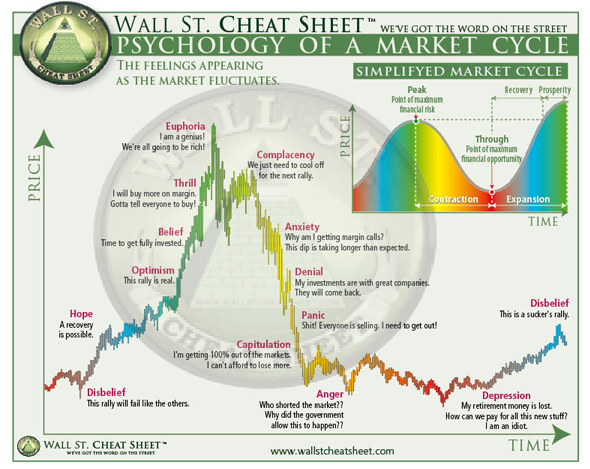

On 17th of December 2017, Bitcoin set its all time high against US Dollar. A whole lot of cryptocurrency market perticipants celebrate as it almost hit 20,000 USD per Bitcoin. But nobody know back then that 19,783$ per BTC was an all time high, just before months of bear market. During the rally, people have taken social networks to express their feelings, opinions and analysis. In this analysis, we will use tweets to measure sentiments just before the all time high to few months after all time high.

In the picture above, after an all time high was set there are "Complacency" state.
> Complacency : A feeling of quiet pleasure or security, often while unaware of some potential danger, defect, or the like.

We will analyze our data to see if the sentiment remain positive during a market downturn after bitcoin set its all time high.


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# html encoding
import html

# regular expression
import re
from tqdm import tqdm

# nlp
from nltk.tokenize import WordPunctTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

## Data Loading
### Tweet Data Loading

In [23]:
# tweets data loading
tweets_data = pd.read_csv('tweets_data.csv', dtype=object)
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1721475 entries, 0 to 1721474
Data columns (total 9 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   id         object
 1   user       object
 2   fullname   object
 3   url        object
 4   timestamp  object
 5   replies    object
 6   likes      object
 7   retweets   object
 8   text       object
dtypes: object(9)
memory usage: 118.2+ MB


In [24]:
# retrieve only necessary columns
tweets_data = tweets_data[['timestamp', 'text']]
# change timestamp dtype into datetime, sorting, retrieve only date from timestamp
tweets_data['timestamp'] = pd.to_datetime(tweets_data['timestamp'])
tweets_data = tweets_data.sort_values(by='timestamp', ascending=True)
tweets_data['date'] = tweets_data['timestamp'].dt.date
tweets_data['date'] = pd.to_datetime(tweets_data['date'])
# filter date only from Dec, 2017 to March, 2018
start_date = '2017-12-01'
end_date = '2018-03-31'
mask = (tweets_data['date'] >= start_date) & (tweets_data['date'] <= end_date)
tweets_data = tweets_data.loc[mask]
tweets_data = tweets_data.reset_index(drop=True)
tweets_data = tweets_data[['date', 'text']]
tweets_data.head()

,date,text
0,2017-12-01,"@ #3, Bitcoin Cash with unit price of $1,337.5..."
1,2017-12-01,"12/01 10:00現在\n\n#Bitcoin : 1,176,520円↓\n#NEM ..."
2,2017-12-01,"Bitcoin - BTC\nPrice: $10,075.90\nChange in 1h..."
3,2017-12-01,One Bitcoin now worth $9900.00@bitstamp. High ...
4,2017-12-01,"01 Aralık 2017 Saat 04:00:02, Bitcoin Ne Kadar..."


In [27]:
# tweets data dimensionality
tweets_data.shape

(641253, 2)

### Price Data Loading

In [39]:
# xbtusd/btcusd 5 minute ticker data loading
xbtusd = pd.read_csv('xbt.csv')
xbtusd = xbtusd[['timestamp', 'open', 'high', 'low', 'close']]

In [40]:
# change timestamp datatype to datetime
xbtusd['timestamp'] = pd.to_datetime(xbtusd['timestamp'])

In [41]:
# filter date only from Dec, 2017 to March, 2018
mask = (xbtusd['timestamp'] > start_date) & (xbtusd['timestamp'] <= end_date)
xbtusd = xbtusd.loc[mask]
xbtusd = xbtusd.reset_index(drop=True)
xbtusd = xbtusd.set_index(['timestamp'])

In [42]:
# resampling 5 minute ticker data into daily
xbtusd = xbtusd.resample('D', label='left').agg({'open':'first', 'high':'max', 'low':'min', 'close':'last'})
# converting timestamp to date
xbtusd['timestamp'] = xbtusd.index
# get date only from timestamp
xbtusd['date'] = xbtusd['timestamp'].dt.date
# change date datatype to datetime
xbtusd['date'] = pd.to_datetime(xbtusd['date'])

In [43]:
xbtusd = xbtusd[['date', 'open', 'high', 'low', 'close']]
xbtusd = xbtusd.reset_index(drop=True)
xbtusd.head()

,date,open,high,low,close
0,2017-12-01,9960.0,10988.0,9347.5,10827.0
1,2017-12-02,10827.0,11262.5,10676.5,10974.0
2,2017-12-03,10974.0,11896.0,10402.0,11080.0
3,2017-12-04,11080.0,11653.0,10856.0,11519.0
4,2017-12-05,11519.0,11961.0,11451.0,11753.5


In [46]:
xbtusd.shape

(121, 5)

## Data Preparation

### Null Value Cleaning

In [28]:
# check null value
tweets_data.isnull().sum(axis=0)

date     0
text    73
dtype: int64

In [30]:
# remove null value
tweets_data = tweets_data.dropna()
tweets_data = tweets_data[['date', 'text']].reset_index(drop=True)
tweets_data.head()

,date,text
0,2017-12-01,"@ #3, Bitcoin Cash with unit price of $1,337.5..."
1,2017-12-01,"12/01 10:00現在\n\n#Bitcoin : 1,176,520円↓\n#NEM ..."
2,2017-12-01,"Bitcoin - BTC\nPrice: $10,075.90\nChange in 1h..."
3,2017-12-01,One Bitcoin now worth $9900.00@bitstamp. High ...
4,2017-12-01,"01 Aralık 2017 Saat 04:00:02, Bitcoin Ne Kadar..."


### Tweets data cleaning

In [33]:
# punctuation tokenizer
tok = WordPunctTokenizer()

# cleaning @ mention
pattern_1 = r'@[A-Za-z0-9]+'

# cleaning url links
pattern_2 = r'https?://[A-Za-z0-9./]+'
combined_pattern = r'|'.join((pattern_1, pattern_2))

def tweet_cleaner(text):
    decoded_html = html.unescape(text)
    stripped = re.sub(combined_pattern, '', decoded_html)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    # cleaning hashtag and numbers
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    # lower case
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [34]:
clean_tweet_texts = []
for i in tqdm(range(len(tweets_data))):                                                        
    clean_tweet_texts.append(tweet_cleaner(tweets_data['text'][i]))

100%|██████████| 641180/641180 [00:23<00:00, 26769.72it/s]


In [71]:
tweets_data['clean_text'] = clean_tweet_texts
tweets_data[['date', 'text', 'clean_text']].head()

,date,text,clean_text
0,2017-12-01,"@ #3, Bitcoin Cash with unit price of $1,337.5...",bitcoin cash with unit price of market cap of ...
1,2017-12-01,"12/01 10:00現在\n\n#Bitcoin : 1,176,520円↓\n#NEM ...",bitcoin nem xem monacoin ethereum zaif
2,2017-12-01,"Bitcoin - BTC\nPrice: $10,075.90\nChange in 1h...",bitcoin btc price change in h market cap ranki...
3,2017-12-01,One Bitcoin now worth $9900.00@bitstamp. High ...,one bitcoin now worth high low market cap bill...
4,2017-12-01,"01 Aralık 2017 Saat 04:00:02, Bitcoin Ne Kadar...",aral k saat bitcoin ne kadar oldu tl bitcointl...


## Data Analysis

We ran our sentiment analysis using VADER, "Valence Aware Dictionary sEntiment Reasoner". It is an excellent sentiment analysis library especially for social media text.

In [38]:
results = []

for tweets in tqdm(tweets_data['clean_text']):
    pol_score = SIA().polarity_scores(tweets)
    pol_score['tweets'] = tweets
    results.append(pol_score)

100%|██████████| 641180/641180 [1:17:21<00:00, 138.13it/s]


In [47]:
# retrieving score data from result list
tweets_data['score'] = pd.DataFrame(results)['compound']

In [48]:
# generating daily sentiment data from grouped by date tweets data 
daily_sentiment = tweets_data.groupby(['date']).mean()
daily_sentiment['date'] = daily_sentiment.index
# change date datatype into datetime
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
daily_sentiment = daily_sentiment[['date', 'score']]
daily_sentiment = daily_sentiment.reset_index(drop=True)
daily_sentiment.head()

,date,score
0,2017-12-01,0.056247
1,2017-12-02,0.042122
2,2017-12-03,0.040406
3,2017-12-04,0.045195
4,2017-12-05,0.038350


In [49]:
daily_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    121 non-null    datetime64[ns]
 1   score   121 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


In [50]:
final = pd.merge(xbtusd, daily_sentiment, how='inner', on='date')

In [51]:
# generating score moving average
final['score_ma'] = final['score'].rolling(10).mean()

In [52]:
final.head()

,date,open,high,low,close,score,score_ma
0,2017-12-01,9960.0,10988.0,9347.5,10827.0,0.056247,NaN
1,2017-12-02,10827.0,11262.5,10676.5,10974.0,0.042122,NaN
2,2017-12-03,10974.0,11896.0,10402.0,11080.0,0.040406,NaN
3,2017-12-04,11080.0,11653.0,10856.0,11519.0,0.045195,NaN
4,2017-12-05,11519.0,11961.0,11451.0,11753.5,0.038350,NaN


## Data Visualization

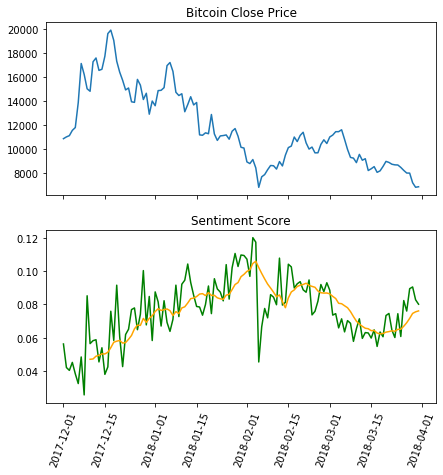

In [61]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (7, 7))
plt.xticks(rotation=70)
ax[0].plot('date', 'close', data=final)
ax[1].plot('date', 'score', data=final, color="green")
ax[1].plot('date', 'score_ma', data=final, color="orange")
ax[0].set_title('Bitcoin Close Price')
ax[1].set_title('Sentiment Score')

plt.show();

## Limitation, Conclusion and Future Scope

This analysis aimed at analyzing the sentiments of market participants around bitcoin all time high, especially after it sets all time high. From our data analysis and visualization that we perform, we can conclude that average sentiment score keep rising from all time high to 2 months after it set. It means that there are complacency periods for around 2 months after bitcoin all time high. The tweets which were collected for this analysis were containing 'Bitcoin or BTC', there are many cryptocurrency that also contain bitcoin on it's name, it might serve as a limitation for this analysis. For the future works, this study can be improved to serve as realtime sentiment index for market participant to improve their trading strategy. 